## Load datasets

load the two CSV files:
- `original_preprocess.csv` (ORAN dataset)
- `dataset_ul.csv` (UL dataset)

also print their shapes to understand the dataset size.

In [201]:
import pandas as pd

oran = pd.read_csv("origin_data/original_preprocess.csv")
ul = pd.read_csv("origin_data/dataset_ul.csv")

In [202]:
print("ORAN raw shape:", oran.shape)
print("UL raw shape  :", ul.shape)

ORAN raw shape: (17501, 39)
UL raw shape  : (20018, 40)


In [203]:
oran.head()
oran.shape
oran.columns

Index(['date', 'BW', 'TM', 'traffic_load_dl', 'traffic_load_ul', 'txgain_dl',
       'txgain_ul', 'selected_mcs_dl', 'selected_mcs_ul',
       'selected_airtime_dl', 'selected_airtime_ul', 'mean_used_mcs_dl',
       'mean_used_mcs_ul', 'bsr_dl', 'bsr_ul', 'gput_ul', 'mean_snr_ul',
       'turbodec_it', 'dec_time', 'nRBs_ul', 'num_ues', 'thr_dl', 'thr_ul',
       'bler_dl', 'bler_ul', 'tbs_dl', 'pm_power', 'pm_var', 'pm_median',
       'n_pm', 'rapl_power', 'rapl_var', 'n_rapl', 'clockspeed', 'airtime_dl',
       'airtime_ul', 'cqi_dl', 'cqi_ul', 'fixed_mcs_flag'],
      dtype='object')

In [204]:
oran.isna().sum()
oran = oran.dropna()
oran = oran[oran["pm_power"] > 0]

In [205]:
ul.shape
ul.columns

Index(['date', 'cpu_platform', 'BW', 'TM', 'UL/DL', 'traffic_load', 'txgain',
       'cpu_time', 'number_active_cores', 'pinning', 'cpu_config',
       'selected_mcs', 'selected_airtime', 'mean_used_mcs', 'bsr', 'num_ues',
       'thr', 'gput', 'mean_snr', 'var_snr', 'bler', 'turbodec_it',
       'rssi_mean', 'rssi_var', 'overflows', 'underflows', 'lates', 'dec_time',
       'pm_power', 'pm_var', 'n_pm', 'rapl_power', 'rapl_var', 'n_rapl',
       'clockspeed', 'nRBs', 'airtime', 'num_subsamples', 'fixed_mcs_flag',
       'failed_experiment'],
      dtype='object')

In [206]:
ul.isna().sum()
ul = ul.dropna()
ul = ul[ul["rapl_power"] > 0]

## Define target and common features

To enable fair comparison and transfer learning, choosing a small set of robust common features that exist in both datasets, which can be mapped easily.

Target variable:
- predict **pm_power** (power meter measurement).  

Selected common features (input X):
- selected_airtime
- selected_mcs
- txgain


This results in a compact aligned dataset with 5 input features and 1 target column.


In [207]:
TARGET = "pm_power"

COMMON_FEATURES = [
    "airtime",
    "selected_mcs",
    "txgain"

]


## ORAN preprocessing and alignment

The ORAN dataset contains separate UL/DL columns (e.g., `airtime_ul`, `traffic_load_ul`).
Since this project focuses on uplink behaviour, extract the UL-related columns and rename them into a shared naming scheme.

Steps:
1) Select the relevant UL columns and the target column.
2) Rename the UL columns (e.g., `airtime_ul` → `airtime`) to match the UL dataset.
3) Convert all selected columns to numeric format.
4) Remove rows with missing values and invalid target values (power ≤ 0).

The output is a cleaned ORAN table with the same column names as the UL table.


In [208]:

oran_colmap = {
    "airtime_ul": "airtime",
    "selected_mcs_ul": "selected_mcs",
    "txgain_ul":"txgain",

    TARGET: TARGET  
}

oran_needed_cols = list(oran_colmap.keys())


oran = oran[oran_needed_cols].copy()
oran = oran.rename(columns=oran_colmap)

for c in COMMON_FEATURES + [TARGET]:
    oran[c] = pd.to_numeric(oran[c], errors="coerce")

oran = oran.dropna(subset=COMMON_FEATURES + [TARGET])
oran = oran[oran[TARGET] > 0]

print("✅ ORAN cleaned shape:", oran.shape)

✅ ORAN cleaned shape: (17501, 4)


## UL preprocessing

The UL dataset only contains ULrecords, and may include failed experiments.

Steps:
1) Filter to keep **UL** records only (`UL/DL == "UL"`).
2) Remove failed experiments (`failed_experiment == 0`).
3) Keep only the selected common features and the target column.
4) Convert selected columns to numeric format.
5) Remove missing values and invalid target values (power ≤ 0).

The output is a cleaned UL table with the same columns as the ORAN table.


In [209]:

# 1) Only retain UL (if there is a UL/DL column)
if "UL/DL" in ul.columns:
    ul = ul[ul["UL/DL"] == "UL"].copy()

# 2) Only filter the conditions：BW=50, traffic_load=24
ul = ul[
    (ul["BW"] == 50) &
    (ul["traffic_load"] == 24)
].copy()

# 3) Column name mapping (alignment ORAN/cam-ready)
ul_colmap = {
    "selected_airtime": "airtime",
    "selected_mcs": "selected_mcs",
    "txgain": "txgain",
    TARGET: TARGET
}

ul_needed_cols = list(ul_colmap.keys())

ul = ul[ul_needed_cols].copy()
ul = ul.rename(columns=ul_colmap)

# 4) numeric clean
for c in COMMON_FEATURES + [TARGET]:
    ul[c] = pd.to_numeric(ul[c], errors="coerce")

ul = ul.dropna(subset=COMMON_FEATURES + [TARGET])
ul = ul[ul[TARGET] > 0]

# 5) airtime is rounded to one decimal 
ul["airtime"] = ul["airtime"].round(1)

print("✅ UL cleaned shape:", ul.shape)
print("UL columns:", ul.columns.tolist())


✅ UL cleaned shape: (9396, 4)
UL columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']


In [210]:


# (1) ORAN：4 columns（input + output）
oran_4cols = oran[COMMON_FEATURES + [TARGET]].copy()

# (2) UL: Conditional Table（BW, traffic_load + input + output）
ul_with_cond = ul.copy()
ul_with_cond.insert(0, "traffic_load", 24)
ul_with_cond.insert(0, "BW", 50)

# (3) UL: A 4-column table without conditions（input + output）
ul_4cols = ul[COMMON_FEATURES + [TARGET]].copy()

# =========================
# 7) Print the information of 2 tables
# =========================

print("\n=== ORAN 4-column table ===")
print("shape:", oran_4cols.shape)
print("columns:", oran_4cols.columns.tolist())
print(oran_4cols.head())

print("\n=== UL 4-column table ===")
print("shape:", ul_4cols.shape)
print("columns:", ul_4cols.columns.tolist())
print(ul_4cols.head())

# =========================
# 8) Column alignment check
# =========================
print("\n=== Column alignment check ===")
print("ORAN columns:", oran_4cols.columns.tolist())
print("UL columns  :", ul_4cols.columns.tolist())

assert oran_4cols.columns.tolist() == ul_4cols.columns.tolist(), \
    "❌ ORAN and UL 4-column tables are not aligned!"

print("✅ ORAN and UL column alignment confirmed.")

# =========================
# 9) SAVE CSV
# =========================
oran_4cols.to_csv("clean_oran_stage1.csv", index=False)
ul_with_cond.to_csv("clean_ul_with_conditions.csv", index=False)
ul_4cols.to_csv("clean_ul_stage1.csv", index=False)

print("\n🎉 Saved files:")
print(" - clean_oran_stage1.csv")
print(" - clean_ul_with_conditions.csv")
print(" - clean_ul_stage1.csv")



=== ORAN 4-column table ===
shape: (17501, 4)
columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']
   airtime  selected_mcs  txgain   pm_power
0      1.0             0      74  13.648015
1      1.0             5      74  13.293121
2      1.0             9      74  13.384308
3      1.0            14      74  13.923219
4      1.0            18      74  14.150091

=== UL 4-column table ===
shape: (9396, 4)
columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']
   airtime  selected_mcs  txgain  pm_power
0      1.0            23      74  13.05631
1      0.9            23      74  13.10550
2      0.8            23      74  12.64807
3      0.7            23      74  11.71501
4      0.6            23      74  12.58539

=== Column alignment check ===
ORAN columns: ['airtime', 'selected_mcs', 'txgain', 'pm_power']
UL columns  : ['airtime', 'selected_mcs', 'txgain', 'pm_power']
✅ ORAN and UL column alignment confirmed.

🎉 Saved files:
 - clean_oran_stage1.csv
 - clean_ul_with_condition

## Visualisation: Power distribution (UL)

Plot the histogram of the target power variable to understand:
- Typical power range
- Whether the distribution is unimodal or multi-modal
- Whether there are abnormal values

A multi-modal distribution can indicate multiple operating regimes (e.g., different system configurations).


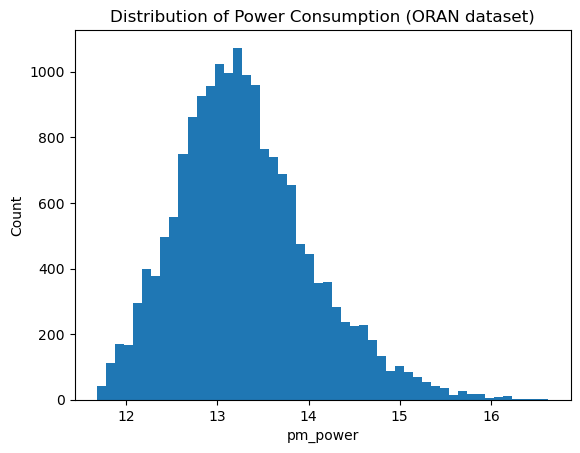

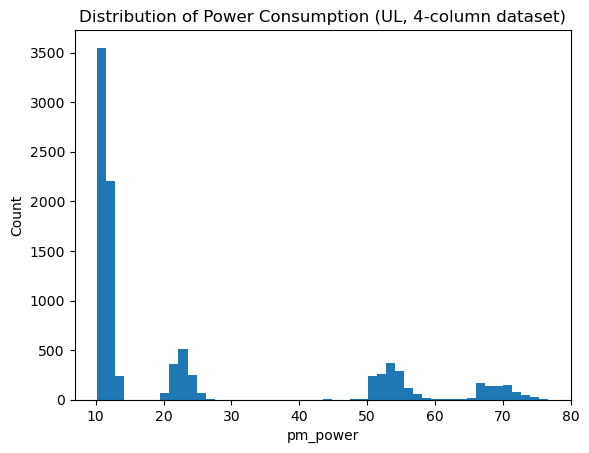

In [211]:

import matplotlib.pyplot as plt

plt.figure()
plt.hist(oran_4cols[TARGET], bins=50)
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.title("Distribution of Power Consumption (ORAN dataset)")
plt.show()


plt.figure()
plt.hist(ul_4cols[TARGET], bins=50)
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.title("Distribution of Power Consumption (UL, 4-column dataset)")
plt.show()





##  Visualisation: Power vs Airtime 

Plot a scatter plot between airtime and power to check whether:
- There is an observable trend
- The relationship appears linear or non-linear
- Multiple power levels exist for the same airtime value 

This supports the motivation for using machine learning rather than simple linear rules.

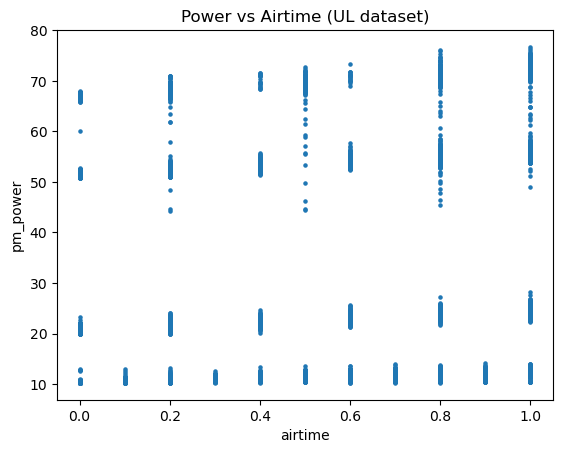

In [212]:
plt.figure()
plt.scatter(ul["airtime"], ul[TARGET], s=5)
plt.xlabel("airtime")
plt.ylabel(TARGET)
plt.title("Power vs Airtime (UL dataset)")
plt.show()


<function matplotlib.pyplot.show(close=None, block=None)>

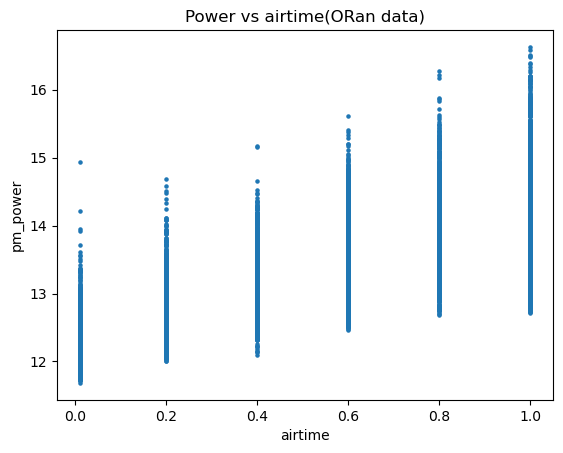

In [213]:
plt.figure()
plt.scatter(oran["airtime"],oran[TARGET],s=5)
plt.xlabel("airtime")
plt.ylabel(TARGET)
plt.title("Power vs airtime(ORan data)")
plt.show

## Visualisation: ORAN vs UL power distribution comparison

Compare the target power distributions across ORAN and UL datasets.
If the distributions differ, this indicates a dataset shift between data sources.

A clear distribution shift motivates transfer learning:
- The task is the same (predict power)
- Feature semantics are aligned
- But the data distributions differ across domains


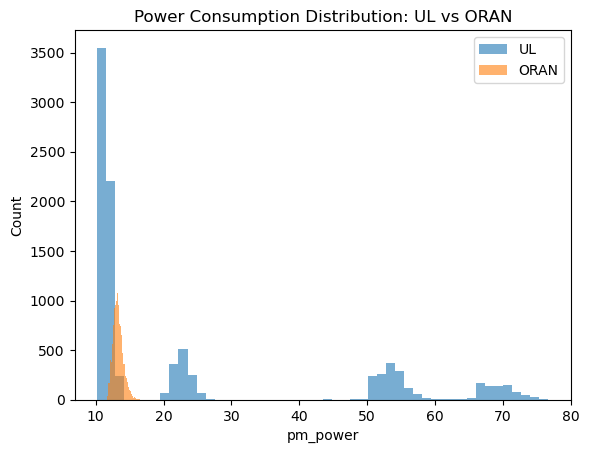

In [214]:
plt.figure()
plt.hist(ul_4cols[TARGET], bins=50, alpha=0.6, label="UL")
plt.hist(oran_4cols[TARGET], bins=50, alpha=0.6, label="ORAN")
plt.xlabel(TARGET)
plt.ylabel("Count")
plt.title("Power Consumption Distribution: UL vs ORAN")
plt.legend()
plt.show()


## Summary 

In Stage 1, cleaned and aligned two independent datasets into a shared feature space consisting of a small set of common features and one power target variable. 

Basic visualisations show:
- The target power distribution in UL is multi-modal, suggesting different operating regimes.
- The relationship between airtime and power is not purely linear.
- ORAN and UL have different power distributions, indicating a distribution shift.

These observations motivate the use of machine learning and transfer learning in the next stages.